In [1]:
#importing the necessary dependencies

import numpy as np
import sys
import scipy
from numpy import array
caffe_root = '/path/to/caffe/'
sys.path.insert(0, caffe_root + 'python')
import caffe
from caffe.proto import caffe_pb2
from skimage import transform
import matplotlib.pyplot as plt
import cv2
import os
import math

%matplotlib inline

In [2]:
#initializing the model

#Specifying to use the GPU
caffe.set_mode_gpu()
caffe.set_device(0)

#Dictionary assigning a layer number to different layers of VGG-16
blob ={0:'conv1_1',1:'conv1_2',2:'pool1',3:'conv2_1',4:'conv2_2',5:'pool2',6:'conv3_1',7:'conv3_2',8:'conv3_3',9:'pool3',10:'conv4_1',11:'conv4_2',12:'conv4_3',13:'pool4',14:'conv5_1',15:'conv5_2',16:'conv5_3',17:'pool5', 18:'fc6', 19:'fc7', 20:'fc8'}
#Hyper-Parameters for Convolution Layers
conv = {'K': 3, 'P': 1, 'S': 1, 'F': 512}
#Hyper-Parameters for Pool Layers
pool = {'K': 2, 'S': 2}
# BGR mean values
mean = np.array([103.939, 116.779, 123.68])

net = caffe.Classifier('../models/vgg_16/deploy.prototxt','../models/vgg_16/vgg_16.caffemodel',channel_swap=(2,1,0))

#The layer currently being backtracked
current_layer = 20
c2c = [16,15,14,12,11,10,8,7,6,4,3,1]
output = []
resFac = 0
inc = 0

In [3]:
#Member Fuctions

def out(values):
#Output points at the end
    global output
    for cr in range(5):
        layer_out = []
        if values[cr]!=0:
            #Bringing points back to image size
            for i in values[cr]:
                layer_out.append((int((i[1]+inc[cr][0])*(1/resFac)),int((i[2]+inc[cr][1])*(1/resFac))))
            output.extend(layer_out)
        

def conv2conv(values):
#Backtrace locations between conv layers
	global current_layer
	for cr in range(5):
		layer_out = []
		if values[cr]!=0:
			for i in values[cr]:
				#Defining receptive field along both axes
				x = (i[1], i[1]+conv['K'])
				y = (i[2], i[2]+conv['K'])
				#Getting and Padding blob data of previous layer
				data = np.lib.pad(net.blobs[blob[current_layer-1]].data[cr,:,:,:],conv['P'], 'constant', constant_values = 0)[1:-1,x[0]:x[1],y[0]:y[1]]
				#The weights of current layer corresponding to channel
				param = net.params[blob[current_layer]][0].data[i[0],:,:,:]
				convolution = data*param
				#Getting most contributing position
				layer_out.append((np.argmax(np.sum(np.sum(convolution,axis=2),axis=1)),x[0],y[0]))
			values[cr] = list(set(layer_out))
	current_layer -= 1
	#Checking which function to call next
	if current_layer == 0:
		out(values)
	elif current_layer in c2c:
		conv2conv(values)
	else:
		pool2conv(values)

def pool2conv(values):
#Backtrace locations from pool to conv layer
	global current_layer
	for cr in range(5):
		layer_out = []
		if values[cr]!=0:
			for i in values[cr]:
				#Getting the receptive region the pool operates on
				x = (pool['S']*i[1], pool['S']*i[1] + pool['K'])
		        	y = (pool['S']*i[2], pool['S']*i[2] + pool['K'])
		        	#Getting most contributing x and y relative to the region being operated on
		        	x1, y1 = np.unravel_index(np.argmax(net.blobs[blob[current_layer-1]].data[cr,i[0],x[0]:x[1],y[0]:y[1]]), [pool['K'],pool['K']])
		        	layer_out.append((i[0],x[0]+x1,y[0]+y1))
			values[cr] = layer_out
        current_layer -= 1
        conv2conv(values)

def fc2pool(values):
#Backtrace locations from fc to pool layer
    global current_layer
    for cr in range(5):
    	layer_out = []
    	#Flattening the blob values to perform in place multiplication
    	data = np.reshape(net.blobs[blob[current_layer-1]].data[cr,:],[25088,])
    	param = net.params[blob[current_layer]][0].data
    	convolution = data*param
	if values[cr]!=0:
			for i in values[cr]:
				#Getting Top positions for each input
				position = np.argmax(convolution[i,:])
				layer_out.append(np.unravel_index(position, net.blobs[blob[current_layer-1]].data.shape[1:]))
			values[cr] = list(set(layer_out))
    current_layer -= 1
    pool2conv(values)

def fc2fc(values):
#Backtrace between fc layers
    global current_layer
    for cr in range(5):
        layer_out = []
        #Blob values for prevous layer
        data = net.blobs[blob[current_layer-1]].data[cr,:]
        #Weights for the current layer
        param = net.params[blob[current_layer]][0].data
        convolution = data*param
        if values[cr]!=0:
            for i in values[cr]:
                #Getting Top-num activations for each input
                num = np.sum(convolution[i,:]>0)
                layer_out.extend(np.argsort(convolution[i,:])[::-1][:num])
            values[cr] = list(set(layer_out))
    current_layer -= 1
    if current_layer == 19:
        fc2fc(values)
    else:
        fc2pool(values)
        
def out_rem(pts, diag):
    values = pts
    neighbors = np.zeros((values.shape[0]))
    selPoints = np.empty((1,2))
    for i in range(values.shape[0]):
        diff = np.sqrt(np.sum(np.square(values-values[i]),axis=1))
        neighbors[i] = np.sum(diff<diag)
    for i in range(values.shape[0]):
        if neighbors[i]>0.05*values.shape[0]:
            selPoints = np.append(selPoints,values[i:i+1,:],axis=0)
    selPoints = selPoints[1:,:]
    selPoints = selPoints.astype(int)
    return selPoints

def heatmap(img, pts, sigma=20):
    k = (np.min(img.shape[:2])) if (np.min(img.shape[:2])%2==1) else (np.min(img.shape[:2])-1)
    mask = np.zeros(img.shape[:2])
    shape = mask.shape
    for i in range(pts.shape[0]):
        if pts[i,0]<shape[0] and pts[i,1]<shape[1]:
            mask[pts[i,0],pts[i,1]] += 1
    blur = cv2.GaussianBlur(mask,(k,k),sigma)
    blur = blur*255/np.max(blur)
    return blur

In [10]:
#loading ilsvrc synset
synsets = open('ilsvrc_synsets.txt').readlines()

#Put the path to test image here
img_path = 'sample.jpg'
img=caffe.io.load_image(img_path)

#Preprocessing the image
resFac = 256.0/min(img.shape[:2])
newSize = map(int,(img.shape[0]*resFac,img.shape[1]*resFac))
img = transform.resize(img, newSize)
net.image_dims = newSize
#The offsets for the crops
inc = [[0,0],[0,newSize[1]-224],[newSize[0]-224,0],[newSize[0]-224,newSize[1]-224],[newSize[0]/2.0-112,newSize[1]/2.0-112]]
img = img*255.0
img[:,:,0]-=mean[2]
img[:,:,1]-=mean[1]
img[:,:,2]-=mean[0]
#Passing image through network
net.predict([img],oversample=True)
p = net.blobs['prob'].data
#The mean label
p_mean = np.argmax(np.mean(p,axis=0))
image_label = synsets[p_mean].split(',')[0].strip()
image_label = image_label[image_label.index(' ')+1:]
crop_labels = [np.argmax(p[0]),np.argmax(p[1]),np.argmax(p[2]),np.argmax(p[3]),np.argmax(p[4])]
#To check if mean label does not match any crop
if p_mean in crop_labels:
    p_m = p_mean
else:
    p_m = crop_labels[4]
crops = []
#To check which crops to consider
for i in range(5):
    if np.argmax(p[i,:])==p_m:
        crops.append(1)
    else:
        crops.append(0)
values = [[],[],[],[],[]]
for cr in range(5):
    if crops[cr]==1:
				values[cr]=[int(p_m)]
    else:
				values[cr]=0
#The amount of evidence to consider
global current_layer
current_layer = 20
global output
output = []
fc2fc(values)

(<matplotlib.image.AxesImage at 0x7fe90ef81750>,
 (-0.5, 499.5, 399.5, -0.5),
 <matplotlib.text.Text at 0x7fe9140989d0>)

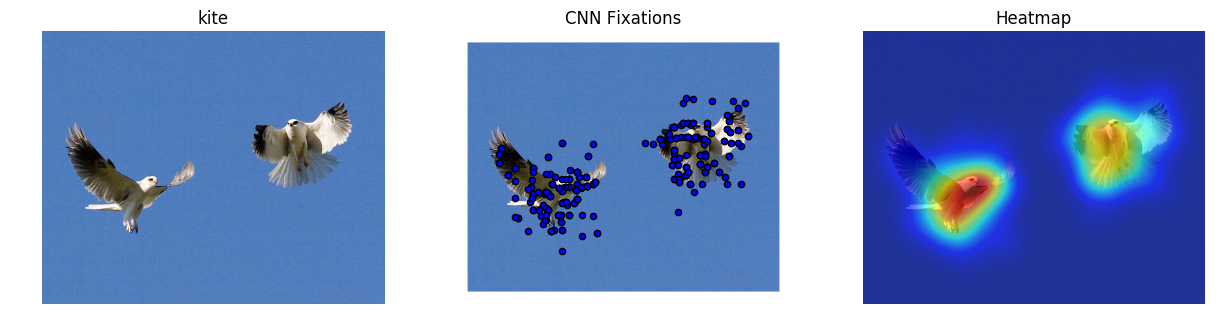

In [11]:
#Visualization
img = cv2.imread(img_path)
b,g,r = cv2.split(img)
img = cv2.merge((r,g,b))
diag = math.sqrt(img.shape[0]**2 + img.shape[1]**2)*0.1
values = np.asarray(output)
selPoints = out_rem(values, diag)
hm = heatmap(np.copy(img), selPoints)

_, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(img),ax[0].axis('off'),ax[0].set_title(image_label)
ax[1].imshow(img),ax[1].axis('off'),ax[1].scatter(selPoints[:,1],selPoints[:,0]),ax[1].set_title('CNN Fixations')
ax[2].imshow(img),ax[2].imshow(hm, alpha=0.6),ax[2].axis('off'),ax[2].set_title('Heatmap')